In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

X_val = pd.read_csv("../data/processed/X_val.csv")
y_val = pd.read_csv("../data/processed/y_val.csv").squeeze("columns")

calibrator = joblib.load("../artifacts/models/calibrator_tuned.joblib")

pd_val = calibrator.predict_proba(X_val)[:, 1]  # probability of default
print("PD sample:", pd_val[:5])
print("ROC-AUC:", roc_auc_score(y_val, pd_val))
print("PR-AUC:", average_precision_score(y_val, pd_val))


PD sample: [0.153745   0.1402915  0.1579055  0.18731324 0.03782215]
ROC-AUC: 0.7792445853305017
PR-AUC: 0.5549157543663917


In [2]:
t_approve = 0.20
t_reject  = 0.35

def decision(pd, t_appr=0.20, t_rej=0.35):
    if pd < t_appr:
        return "APPROVE"
    elif pd < t_rej:
        return "REVIEW"
    else:
        return "REJECT"

decisions = np.array([decision(p, t_approve, t_reject) for p in pd_val])
pd.Series(decisions).value_counts(normalize=True)


APPROVE    0.678167
REJECT     0.188500
REVIEW     0.133333
Name: proportion, dtype: float64

In [3]:
C_DEFAULT_APPROVED = 100   # big loss
C_GOOD_REJECTED    = 10    # opportunity cost
C_REVIEW           = 2     # operational cost

def total_cost(y_true, pd, t_appr, t_rej):
    # decisions
    # approve: pd < t_appr
    # review:  t_appr <= pd < t_rej
    # reject:  pd >= t_rej

    y_true = np.asarray(y_true)
    pd = np.asarray(pd)

    approve = pd < t_appr
    review  = (pd >= t_appr) & (pd < t_rej)
    reject  = pd >= t_rej

    # cost components
    # approve but actually default (y=1)
    cost_default_approved = C_DEFAULT_APPROVED * np.sum(approve & (y_true == 1))
    # reject but actually good (y=0)
    cost_good_rejected = C_GOOD_REJECTED * np.sum(reject & (y_true == 0))
    # review cost for everyone reviewed
    cost_review = C_REVIEW * np.sum(review)

    return cost_default_approved + cost_good_rejected + cost_review

# grid search thresholds
t_appr_grid = np.linspace(0.05, 0.35, 31)
t_rej_grid  = np.linspace(0.20, 0.70, 51)

best = None
best_cost = float("inf")

for t_appr in t_appr_grid:
    for t_rej in t_rej_grid:
        if t_rej <= t_appr:
            continue
        c = total_cost(y_val, pd_val, t_appr, t_rej)
        if c < best_cost:
            best_cost = c
            best = (t_appr, t_rej)

best, best_cost


((np.float64(0.05), np.float64(0.7)), np.int64(13040))

In [14]:
best_t_approve, best_t_reject = best
print("Best thresholds:", best_t_approve,",", best_t_reject)

decisions_best = np.array([decision(p, best_t_approve, best_t_reject) for p in pd_val])
pd.Series(decisions_best).value_counts(normalize=True)


Best thresholds: 0.05 , 0.7


REVIEW     0.873333
APPROVE    0.071000
REJECT     0.055667
Name: proportion, dtype: float64

In [5]:
def policy_outcomes(y_true, pd, t_appr, t_rej):
    y_true = np.asarray(y_true)
    pd = np.asarray(pd)

    approve = pd < t_appr
    review  = (pd >= t_appr) & (pd < t_rej)
    reject  = pd >= t_rej

    out = {
        "approve_rate": approve.mean(),
        "review_rate": review.mean(),
        "reject_rate": reject.mean(),
        "default_rate_overall": y_true.mean(),
        "default_rate_approved": y_true[approve].mean() if approve.sum() else np.nan,
        "default_rate_review": y_true[review].mean() if review.sum() else np.nan,
        "default_rate_reject": y_true[reject].mean() if reject.sum() else np.nan,
        "n_approved": int(approve.sum()),
        "n_review": int(review.sum()),
        "n_reject": int(reject.sum()),
        "total_cost": total_cost(y_true, pd, t_appr, t_rej),
    }
    return out

policy_outcomes(y_val, pd_val, best_t_approve, best_t_reject)


{'approve_rate': np.float64(0.071),
 'review_rate': np.float64(0.8733333333333333),
 'reject_rate': np.float64(0.05566666666666667),
 'default_rate_overall': np.float64(0.22116666666666668),
 'default_rate_approved': np.float64(0.04225352112676056),
 'default_rate_review': np.float64(0.20057251908396947),
 'default_rate_reject': np.float64(0.7724550898203593),
 'n_approved': 426,
 'n_review': 5240,
 'n_reject': 334,
 'total_cost': np.int64(13040)}

In [6]:
import json, os
os.makedirs("../artifacts/reports", exist_ok=True)

thresholds = {
    "t_approve": float(best_t_approve),
    "t_reject": float(best_t_reject),
    "costs": {
        "C_DEFAULT_APPROVED": C_DEFAULT_APPROVED,
        "C_GOOD_REJECTED": C_GOOD_REJECTED,
        "C_REVIEW": C_REVIEW
    }
}

with open("../artifacts/reports/thresholds.json", "w") as f:
    json.dump(thresholds, f, indent=2)

thresholds


{'t_approve': 0.05,
 't_reject': 0.7,
 'costs': {'C_DEFAULT_APPROVED': 100, 'C_GOOD_REJECTED': 10, 'C_REVIEW': 2}}

In [7]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    calibrator,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = pd.DataFrame({
    "feature": X_val.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

importances.head(10)


,feature,importance_mean,importance_std
6,PAY_0,0.079000,0.002788
1,LIMIT_BAL,0.000583,0.000616
17,BILL_AMT6,0.000517,0.000617
13,BILL_AMT2,0.000350,0.000293
21,PAY_AMT4,0.000317,0.000302
15,BILL_AMT4,0.000300,0.000521
20,PAY_AMT3,0.000250,0.000417
12,BILL_AMT1,0.000233,0.000807
18,PAY_AMT1,0.000133,0.000710
3,EDUCATION,0.000100,0.000374


In [8]:
def reason_codes(sample_idx, X, model, importances, top_n=3):
    x = X.iloc[sample_idx:sample_idx+1].copy()
    base_pd = model.predict_proba(x)[0, 1]

    impacts = []
    for feat in importances["feature"].head(15):
        x_perturbed = x.copy()
        x_perturbed[feat] = X[feat].mean()
        new_pd = model.predict_proba(x_perturbed)[0, 1]
        impacts.append((feat, base_pd - new_pd))

    impacts = sorted(impacts, key=lambda x: abs(x[1]), reverse=True)
    return base_pd, impacts[:top_n]


In [9]:
# find example indices
idx_reject = np.where(decisions_best == "REJECT")[0][0]
idx_approve = np.where(decisions_best == "APPROVE")[0][0]

pd_reject, reasons_reject = reason_codes(idx_reject, X_val, calibrator, importances)
pd_approve, reasons_approve = reason_codes(idx_approve, X_val, calibrator, importances)

pd_reject, reasons_reject, pd_approve, reasons_approve


(np.float64(0.7727463083481938),
 [('PAY_0', np.float64(0.25054842590934756)),
  ('PAY_AMT1', np.float64(0.04913580246913585)),
  ('BILL_AMT3', np.float64(0.04913580246913585))],
 np.float64(0.03782215395118621),
 [('BILL_AMT2', np.float64(0.01470794026105629)),
  ('LIMIT_BAL', np.float64(-0.006669961076643104)),
  ('BILL_AMT4', np.float64(-0.0036607018173838435))])

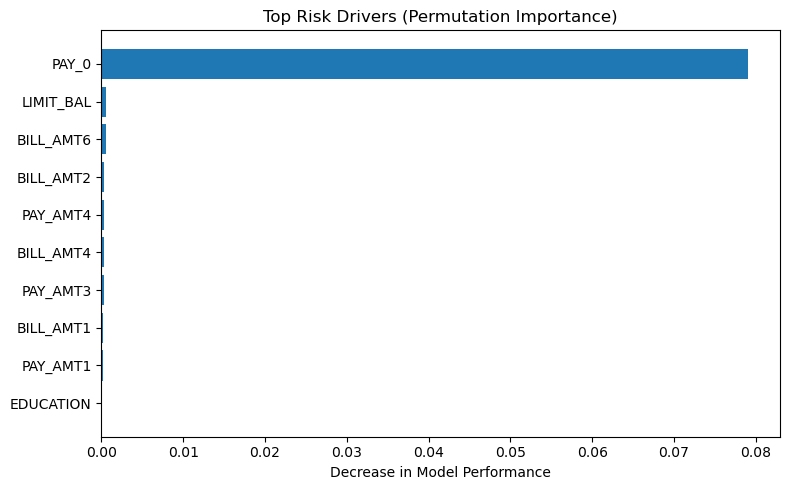

In [10]:
import os
import matplotlib.pyplot as plt

os.makedirs("../artifacts/reports/figures", exist_ok=True)

top_k = 10
top = importances.head(top_k).copy()

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top["feature"][::-1], top["importance_mean"][::-1])
ax.set_title("Top Risk Drivers (Permutation Importance)")
ax.set_xlabel("Decrease in Model Performance")

fig.tight_layout()
fig.savefig("../artifacts/reports/figures/feature_importance.png", dpi=200)
plt.show()


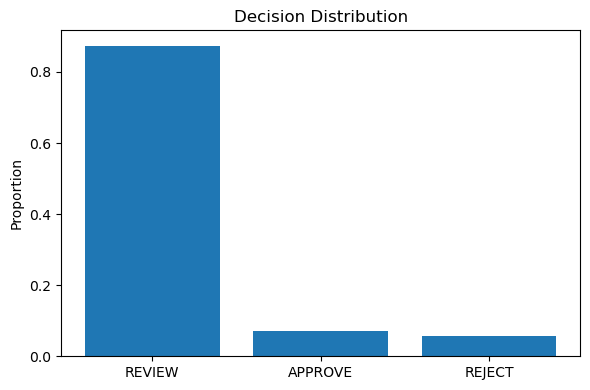

In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt

os.makedirs("../artifacts/reports/figures", exist_ok=True)

counts = pd.Series(decisions_best).value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(counts.index, counts.values)
ax.set_title("Decision Distribution")
ax.set_ylabel("Proportion")

fig.tight_layout()
fig.savefig("../artifacts/reports/figures/decision_distribution.png", dpi=200)
plt.show()


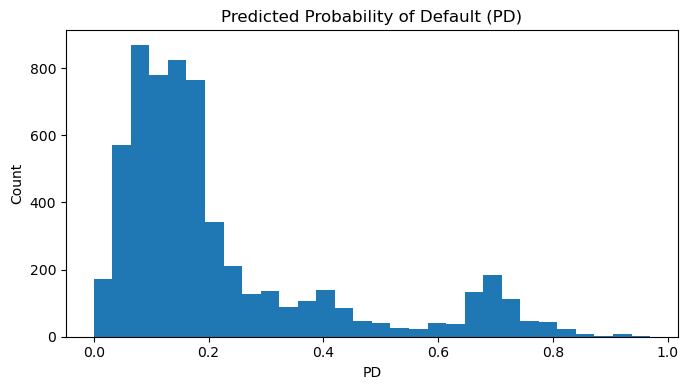

In [12]:
import os
import matplotlib.pyplot as plt

os.makedirs("../artifacts/reports/figures", exist_ok=True)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(pd_val, bins=30)
ax.set_title("Predicted Probability of Default (PD)")
ax.set_xlabel("PD")
ax.set_ylabel("Count")

fig.tight_layout()
fig.savefig("../artifacts/reports/figures/pd_distribution.png", dpi=200)
plt.show()


In [16]:
import json, os
os.makedirs("../artifacts/reports", exist_ok=True)

thresholds_tuned = {
    "model": "HistGB_Tuned + Isotonic Calibrator",
    "t_approve": float(best_t_approve),
    "t_reject": float(best_t_reject),
    "costs": {
        "C_DEFAULT_APPROVED": float(C_DEFAULT_APPROVED),
        "C_GOOD_REJECTED": float(C_GOOD_REJECTED),
        "C_REVIEW": float(C_REVIEW)
    }
}

with open("../artifacts/reports/thresholds_tuned.json", "w") as f:
    json.dump(thresholds_tuned, f, indent=2)

print("Saved thresholds_tuned.json")
thresholds_tuned


Saved thresholds_tuned.json


{'model': 'HistGB_Tuned + Isotonic Calibrator',
 't_approve': 0.05,
 't_reject': 0.7,
 'costs': {'C_DEFAULT_APPROVED': 100.0,
  'C_GOOD_REJECTED': 10.0,
  'C_REVIEW': 2.0}}

In [17]:
policy = policy_outcomes(y_val, pd_val, best_t_approve, best_t_reject)

policy_clean = {k: float(v) if hasattr(v, "item") else v for k, v in policy.items()}

with open("../artifacts/reports/policy_summary_tuned.json", "w") as f:
    json.dump(policy_clean, f, indent=2)

print("Saved policy_summary_tuned.json")
policy_clean


Saved policy_summary_tuned.json


{'approve_rate': 0.071,
 'review_rate': 0.8733333333333333,
 'reject_rate': 0.05566666666666667,
 'default_rate_overall': 0.22116666666666668,
 'default_rate_approved': 0.04225352112676056,
 'default_rate_review': 0.20057251908396947,
 'default_rate_reject': 0.7724550898203593,
 'n_approved': 426,
 'n_review': 5240,
 'n_reject': 334,
 'total_cost': 13040.0}